# NLP Assignment 4
## Samarth Ramesh

In [ ]:
import os
import json
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import string
import time
import math
from tqdm import tqdm
import re
import pickle
from pprint import pprint
import statistics
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

The required input for the character-based RNN is a long string of text from which the model can be trained on random chunks. So each paper is extracted from the corresponding json and all the data is concatenated to form one long string. 

While training the model would often struggle to properly predict the behaviour of bracket characters because of the large number of brackets present both in that text and as direction to the references. So I removed any text between brackets to improve the model's text generation. 

I also fixed some inconsistencies in the spacing around full stops and commas so that the model improves at predicting punctuation.

In [ ]:
def extract_text(filename,output_as_list=False):
  '''
  Extract the text from the file name (json file) and
  index the content from paper_id, title, abstract and body_text fields
  Retuns - if output_as_list = True
             list of all the above values,
           else
             text of title, abstract and bodt_text
  '''

  file = open(filename)
  body_text = ""
  abstract = ""
  title = ""
  paper_id = ""

  paper_content = json.load(file)

  #get the paper_id
  if 'paper_id' in paper_content:
    paper_id = paper_content['paper_id']
  #get the title, if available
  if 'title' in paper_content['metadata']:
    title = paper_content['metadata']['title']
  #get abstract.text, if available
  if 'abstract' in paper_content:
    for abs in paper_content['abstract']:
      abstract = abstract + abs['text']
  if 'body_text' in paper_content:
    for bt in paper_content['body_text']:
      body_text = body_text + bt['text']


  if output_as_list:
    return [paper_id,title,abstract,body_text]
  else:
    return (title + ' ' + abstract + ' ' + body_text + ' ')

def remove_brackets(sentence):
  '''
  This function uses regular expressions to remove any part
  of the sentences contained between brackets.
  '''
  return re.sub(".[\(\[].*?[\)\]]", "", sentence)

def fix_punc(sentence):
  '''
  Corrects the spacing errors around commas and full stops.
  '''
  return re.sub("\s\.", '.', re.sub("\.(?!\s|$)", ". ", re.sub("\s\,", ",", re.sub("\,(?!\s|$)", ", ", sentence))))


In [ ]:
'''
papers_data = []
i = 0
for filename in os.listdir("/content/drive/MyDrive/Colab Data/NLP 1 Data"):
  paper = extract_text("/content/drive/MyDrive/Colab Data/NLP 1 Data/" + filename, output_as_list= False)
  papers_data.append(paper)
  i+=1
  print(i)

data=""
for paper in papers_data:
  data+=paper

data = fix_punc(remove_brackets(data))

with open('/content/drive/MyDrive/Colab Data/NLP 4 Data/final_data.txt', 'w') as filename:
  filename.write(data)
  filename.close()
'''

In [ ]:
with open('/content/drive/MyDrive/Colab Data/NLP 4 Data/final_data.txt', 'r+') as filename:
  data = filename.readline()

In [ ]:
total_char = len(data)
total_char

8451640

# Model

I tried a combination unidirectional and bidirectional RNNs in conjencture with all the different possible optimisation algorithms and settled on the best performing architectures which a Bidirectional GRU with the Adamax algorithm.


The accuracy was shown to increase with larger number of stacked layer and increase in hidden layer size. I chose 2 stacked layers and a hidden layer size of 200.

In [ ]:
class CharRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1, bidir = False, dp = 0):
    super(CharRNN, self).__init__()
    self.model = model.lower()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.bidir = bidir
    self.dp = dp

    self.encoder = nn.Embedding(input_size, hidden_size)
    if self.model == "gru":
      self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional = bidir, dropout = dp)
    elif self.model == "lstm":
      self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = bidir, dropout = dp)
        
    if self.bidir == True:
      self.decoder = nn.Linear(hidden_size*2, output_size)
    elif self.bidir == False:
      self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    batch_size = input.size(0)
    encoded = self.encoder(input)
    output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
    output = self.decoder(output.view(batch_size, -1))
    return output, hidden

  def forward2(self, input, hidden):
    encoded = self.encoder(input.view(1, -1))
    output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
    output = self.decoder(output.view(1, -1))
    return output, hidden

  def init_hidden(self, batch_size):
    if self.bidir == True:
      if self.model == "lstm":
        return (Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size)),
                Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size)))
      else:
        return Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size))
    if self.model == "lstm":
      return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
              Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
    return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

all_characters = string.printable
n_characters = len(all_characters)

# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    try:
      tensor[c] = all_characters.index(string[c])
    except:
      continue
  return tensor

def random_training_set(chunk_len, batch_size):
  inp = torch.LongTensor(batch_size, chunk_len)
  target = torch.LongTensor(batch_size, chunk_len)
  for bi in range(batch_size):
    start_index = random.randint(0, total_char - chunk_len)
    end_index = start_index + chunk_len + 1
    chunk = data[start_index:end_index]
    inp[bi] = char_tensor(chunk[:-1])
    target[bi] = char_tensor(chunk[1:])
  inp = Variable(inp)
  target = Variable(target)
  if cuda:
    inp = inp.cuda()
    target = target.cuda()
  return inp, target

global acc_list

def train(inp, target):
  hidden = decoder.init_hidden(batch_size)
  if model == "gru":
    if cuda:
      hidden = hidden.cuda()
  if model == "lstm":
    if cuda:
      hidden = (hidden[0].cuda(), hidden[1].cuda())
  decoder.zero_grad()
  loss = 0

  for c in range(chunk_len):
    output, hidden = decoder(inp[:,c], hidden)
    acc_list.append(find_acc(output, target[:,c]))
    loss += criterion(output.view(batch_size, -1), target[:,c])

  loss.backward()
  decoder_optimizer.step()

  return loss.data.item() / chunk_len


def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
  hidden = decoder.init_hidden(1)
  prime_input = Variable(char_tensor(prime_str).unsqueeze(0))
  if model == "gru":
    if cuda:
      hidden = hidden.cuda()
      prime_input = prime_input.cuda()
  if model == "lstm":    
    if cuda:
      hidden = (hidden[0].cuda(), hidden[1].cuda())
      prime_input = prime_input.cuda()
  predicted = prime_str

  # Use priming string to "build up" hidden state
  for p in range(len(prime_str) - 1):
    _, hidden = decoder(prime_input[:,p], hidden)
        
  inp = prime_input[:,-1]
   
  for p in range(predict_len):
    output, hidden = decoder(inp, hidden)
        
    # Sample from the network as a multinomial distribution
    output_dist = output.data.view(-1).div(temperature).exp()
    top_i = torch.multinomial(output_dist, 1)[0]

    # Add predicted character to string and use as next input
    predicted_char = all_characters[top_i]
    predicted += predicted_char
    inp = Variable(char_tensor(predicted_char).unsqueeze(0))
    if cuda:
      inp = inp.cuda()

  return predicted

def time_since(since):
  s = time.time() - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def find_acc(output_tensor, target_tensor):
  predictions = []
  for preds in output_tensor:
    predsl = preds.tolist()
    pred_char = predsl.index(max(predsl))
    predictions.append(pred_char)
  targets = target_tensor.tolist()
  correct = 0
  for i in range(len(predictions)):
    if predictions[i] == targets[i]:
      correct+=1
  return correct/len(predictions)

def save(path = '/content/drive/MyDrive/Colab Data/dummy.pt'):
  torch.save(decoder, path)
  print("Saving...")

def generate_sample(decoder, prime_str = "The", predict_len = 200, cuda = False):
  predicted = generate(decoder=decoder, prime_str=prime_str, predict_len=predict_len+200, cuda=cuda)
  for i in range(len(predicted)):
    if i > predict_len and predicted[i] == '.':
      predicted = predicted[:i+1]
      break
  return predicted

# Training

The model was trained for 10000 epochs on a batch size of 64 random chunks of data. The learning rate is initially set 0.01 and reduced by a afactor 0.95 everytime the model trains for 100 epochs without achieving a new minimum loss.
The model took around 2 hours to train on Google Colab GPU.

In [ ]:
#Hyperparameters
hidden_size = 200
model = "gru"
n_layers = 2
learning_rate = 0.01
lr_decay = 0.95
steps_decay = 100
n_epochs = 10000
chunk_len = 200
batch_size = 64
print_every = 250
save_path = '/content/drive/MyDrive/Colab Data/NLP 4 Models/final_model.pt'
losses_path = '/content/drive/MyDrive/Colab Data/NLP 4 Data/final_lossesv2.pkl'
acc_path = '/content/drive/MyDrive/Colab Data/NLP 4 Data/final_accsv2.pkl'

In [ ]:
cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if os.path.exists(save_path):
  decoder = torch.load(save_path)
  print("Loading pretrained model", '\n')
else:
  decoder = CharRNN(n_characters, hidden_size, n_characters, model=model, n_layers=n_layers, bidir = True)

if cuda:
  decoder.cuda()
  print("Using CUDA")

acc_list = []

decoder_optimizer = torch.optim.Adamax(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size = 1, gamma=lr_decay, last_epoch=-1)

start = time.time()

if os.path.exists(losses_path):
  with open(losses_path, 'rb') as f:
    train_losses = pickle.load(f)
else:
  train_losses = []

if os.path.exists(acc_path):
  with open(acc_path, 'rb') as f:
    train_acc = pickle.load(f)
else:
  train_acc = []

lr = learning_rate

if len(train_acc) == 0:
  min_loss = 1000
else:
  min_loss = min(train_losses)

last_min = 0

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
  acc_list = []
  loss = train(*random_training_set(chunk_len, batch_size))
  train_losses.append(loss)
  train_acc.append(statistics.mean(acc_list))

  if loss < min_loss:
    min_loss = loss
    last_min = 0
  
  last_min +=1

  if last_min > steps_decay:
    scheduler.step()
    last_min = 0
    lr = lr*lr_decay
    print('\n'+"New Learning Rate: "+str(lr)+'\n')


  if epoch % print_every == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
    print(generate(decoder, 'The', 100, cuda=cuda), '\n')
    with open(losses_path, 'wb') as f:
      pickle.dump(train_losses, f)
      f.close
    with open(acc_path, 'wb') as f:
      pickle.dump(train_acc, f)
      f.close
    save('/content/drive/MyDrive/Colab Data/NLP 4 Models/final_model.pt')
  

  0%|          | 0/10000 [00:00<?, ?it/s]

Using CUDA
Training for 10000 epochs...


  2%|▏         | 249/10000 [02:40<1:44:15,  1.56it/s]

 41s (250 2%) 1.4070]
The formation difficient mofile der contains were this contribution of the extraces facilitate one prom 



  2%|▎         | 250/10000 [02:41<2:06:59,  1.28it/s]

Saving...


  5%|▌         | 500/10000 [05:22<1:47:35,  1.47it/s]

 21s (500 5%) 1.2926]
The following countries, anti-might responses of SARS CoV Servick virus between 5 0 GDx this strategy b 

Saving...


  8%|▊         | 750/10000 [08:03<1:44:07,  1.48it/s]

 3s (750 7%) 1.2709]
Therapeutic cost for strains outbreaks for proim el as important to the response to be submitted about  

Saving...


 10%|▉         | 983/10000 [10:33<1:36:46,  1.55it/s]


New Learning Rate: 0.0095



 10%|█         | 1000/10000 [10:44<1:43:12,  1.45it/s]

 44s (1000 10%) 1.2181]
The south specific antibounational and lower states and the therapies in Alakins species with an auto m 

Saving...


 11%|█         | 1084/10000 [11:39<1:36:27,  1.54it/s]


New Learning Rate: 0.009025



 12%|█▎        | 1250/10000 [13:29<1:39:48,  1.46it/s]

 29s (1250 12%) 1.1692]
The macrophage in the local limited for did not comment rate of the use of experimental BMI with the 20 

Saving...


 13%|█▎        | 1270/10000 [13:42<1:34:52,  1.53it/s]


New Learning Rate: 0.00857375



 14%|█▍        | 1382/10000 [14:55<1:33:17,  1.54it/s]


New Learning Rate: 0.0081450625



 15%|█▌        | 1500/10000 [16:11<1:36:39,  1.47it/s]

 11s (1500 15%) 1.1962]
The interpreted strain, influenza virus influenza and to be performed as broad discretion. They cause p 

Saving...


 15%|█▌        | 1517/10000 [16:22<1:29:39,  1.58it/s]


New Learning Rate: 0.007737809374999999



 17%|█▋        | 1701/10000 [18:20<1:28:21,  1.57it/s]


New Learning Rate: 0.007350918906249998



 18%|█▊        | 1750/10000 [18:52<1:33:22,  1.47it/s]

 52s (1750 17%) 1.1574]
The key range of mRNA is an abdoment flow of site to sample to symptom is but was immunized by asthma p 

Saving...


 18%|█▊        | 1840/10000 [19:50<1:29:18,  1.52it/s]


New Learning Rate: 0.006983372960937498



 20%|█▉        | 1954/10000 [21:03<1:24:51,  1.58it/s]


New Learning Rate: 0.006634204312890623



 20%|██        | 2000/10000 [21:32<1:29:34,  1.49it/s]

 32s (2000 20%) 1.1658]
The resource grants from the need for antisense statements in the copyright holder for the biological a 

Saving...


 21%|██▏       | 2143/10000 [23:06<1:25:38,  1.53it/s]


New Learning Rate: 0.006302494097246091



 22%|██▎       | 2250/10000 [24:17<1:29:17,  1.45it/s]

 16s (2250 22%) 1.1079]
The strains shock to resulting in the second was significant from less than n. An additional and innova 

Saving...


 23%|██▎       | 2326/10000 [25:07<1:23:54,  1.52it/s]


New Learning Rate: 0.005987369392383786



 24%|██▍       | 2443/10000 [26:24<1:21:34,  1.54it/s]


New Learning Rate: 0.005688000922764597



 25%|██▌       | 2500/10000 [27:01<1:25:58,  1.45it/s]

 1s (2500 25%) 1.1528]
The histosum and support communication of interferon settings showed that the telomeric UpS could be le 

Saving...


 25%|██▌       | 2544/10000 [27:30<1:20:47,  1.54it/s]


New Learning Rate: 0.005403600876626367



 26%|██▋       | 2645/10000 [28:36<1:20:03,  1.53it/s]


New Learning Rate: 0.005133420832795048



 27%|██▋       | 2746/10000 [29:41<1:18:33,  1.54it/s]


New Learning Rate: 0.0048767497911552955



 28%|██▊       | 2750/10000 [29:44<1:22:50,  1.46it/s]

 44s (2750 27%) 1.1491]
The bone research author showing the submitted work, such as follows: Funding coronaviruses, as more se 

Saving...


 29%|██▉       | 2933/10000 [31:43<1:16:51,  1.53it/s]


New Learning Rate: 0.00463291230159753



 30%|███       | 3000/10000 [32:26<1:19:41,  1.46it/s]

 26s (3000 30%) 1.0869]
The city syndrome and the regulatory enzyme, they are disciplines of infection, please viral entity or  

Saving...


 30%|███       | 3043/10000 [32:54<1:15:07,  1.54it/s]


New Learning Rate: 0.0044012666865176535



 31%|███▏      | 3144/10000 [34:00<1:14:34,  1.53it/s]


New Learning Rate: 0.004181203352191771



 32%|███▎      | 3250/10000 [35:09<1:17:22,  1.45it/s]

 8s (3250 32%) 1.0946]
The proposed measures expected to the antiviral activities and given those health articles participatio 

Saving...


 33%|███▎      | 3294/10000 [35:37<1:11:54,  1.55it/s]


New Learning Rate: 0.003972143184582182



 35%|███▌      | 3500/10000 [37:50<1:13:08,  1.48it/s]

 50s (3500 35%) 1.0823]
The control complements with growth factor-specific factors that you received, either designed to be in 

Saving...


 35%|███▌      | 3543/10000 [38:18<1:08:38,  1.57it/s]


New Learning Rate: 0.0037735360253530726



 36%|███▋      | 3644/10000 [39:23<1:07:48,  1.56it/s]


New Learning Rate: 0.0035848592240854188



 37%|███▋      | 3745/10000 [40:28<1:07:42,  1.54it/s]


New Learning Rate: 0.0034056162628811476



 38%|███▊      | 3750/10000 [40:31<1:11:45,  1.45it/s]

 31s (3750 37%) 1.0853]
The control practice may need to deal with reduction in transmissions automatically substantial materia 

Saving...


 38%|███▊      | 3846/10000 [41:33<1:05:23,  1.57it/s]


New Learning Rate: 0.0032353354497370902



 39%|███▉      | 3947/10000 [42:38<1:04:14,  1.57it/s]


New Learning Rate: 0.0030735686772502355



 40%|████      | 4000/10000 [43:12<1:07:50,  1.47it/s]

 12s (4000 40%) 1.0316]
The correlation of the intercellular province and seropositive substrates and the majority of these ins 

Saving...


 40%|████      | 4048/10000 [43:43<1:03:20,  1.57it/s]


New Learning Rate: 0.0029198902433877237



 41%|████▏     | 4149/10000 [44:48<1:02:00,  1.57it/s]


New Learning Rate: 0.0027738957312183374



 42%|████▎     | 4250/10000 [45:53<1:04:31,  1.49it/s]

 53s (4250 42%) 1.0601]
The denia et al. demonstrated that viral replication is present in the Privacy. Results showed that pro 

Saving...


 44%|████▍     | 4429/10000 [47:50<1:00:09,  1.54it/s]


New Learning Rate: 0.0026352009446574203



 45%|████▌     | 4500/10000 [48:36<1:02:41,  1.46it/s]

 36s (4500 45%) 1.0608]
The process of patients with a comparative exporting source of a tools and programmed cancer range of s 

Saving...


 45%|████▌     | 4530/10000 [48:56<58:52,  1.55it/s]


New Learning Rate: 0.002503440897424549



 46%|████▋     | 4631/10000 [50:01<57:28,  1.56it/s]


New Learning Rate: 0.0023782688525533216



 47%|████▋     | 4732/10000 [51:05<56:13,  1.56it/s]


New Learning Rate: 0.0022593554099256553



 48%|████▊     | 4750/10000 [51:17<58:45,  1.49it/s]

 17s (4750 47%) 1.0293]
The process of direct polarisation algorithm was not contributed to also for the orientation which are  

Saving...


 48%|████▊     | 4833/10000 [52:10<54:26,  1.58it/s]


New Learning Rate: 0.0021463876394293723



 49%|████▉     | 4937/10000 [53:16<54:07,  1.56it/s]


New Learning Rate: 0.0020390682574579037



 50%|█████     | 5000/10000 [53:57<55:51,  1.49it/s]

 57s (5000 50%) 1.0028]
The "preprint" "fenested COVID-19 brain forms, we also began to determine the observed severe stimulati 

Saving...


 50%|█████     | 5038/10000 [54:21<53:11,  1.55it/s]


New Learning Rate: 0.0019371148445850085



 51%|█████▏    | 5139/10000 [55:28<52:46,  1.53it/s]


New Learning Rate: 0.0018402591023557579



 52%|█████▎    | 5250/10000 [56:40<54:12,  1.46it/s]

 39s (5250 52%) 1.0920]
The ORF1b proteins is a correlation to a cats and learning growth with a non-standard upregulation of d 

Saving...


 53%|█████▎    | 5283/10000 [57:01<50:19,  1.56it/s]


New Learning Rate: 0.0017482461472379698



 54%|█████▍    | 5384/10000 [58:05<49:00,  1.57it/s]


New Learning Rate: 0.0016608338398760713



 55%|█████▍    | 5485/10000 [59:10<48:39,  1.55it/s]


New Learning Rate: 0.0015777921478822676



 55%|█████▌    | 5500/10000 [59:20<50:38,  1.48it/s]

 20s (5500 55%) 1.0477]
The consent was developed as or other three microbial control shedding approach for ICU can isolate the 

Saving...


 56%|█████▌    | 5586/10000 [1:00:15<47:07,  1.56it/s]


New Learning Rate: 0.001498902540488154



 57%|█████▋    | 5687/10000 [1:01:20<45:43,  1.57it/s]


New Learning Rate: 0.0014239574134637463



 57%|█████▊    | 5750/10000 [1:02:01<48:00,  1.48it/s]

 1s (5750 57%) 0.9949]
The patent has been presented in Table 9 : Figure 18, 2020. Comment 10 0gro with 10 10 bp for 60 mM HBo 

Saving...


 58%|█████▊    | 5833/10000 [1:02:54<44:33,  1.56it/s]


New Learning Rate: 0.0013527595427905588



 60%|█████▉    | 5990/10000 [1:04:35<43:02,  1.55it/s]


New Learning Rate: 0.0012851215656510308



 60%|██████    | 6000/10000 [1:04:42<45:35,  1.46it/s]

 42s (6000 60%) 0.9498]
The stimulatory proprioception at the case of CNS virus, or antibodies to the spaces bit samples show t 

Saving...


 61%|██████    | 6091/10000 [1:05:41<42:38,  1.53it/s]


New Learning Rate: 0.0012208654873684791



 62%|██████▏   | 6192/10000 [1:06:46<40:49,  1.55it/s]


New Learning Rate: 0.0011598222130000551



 62%|██████▎   | 6250/10000 [1:07:23<42:05,  1.48it/s]

 23s (6250 62%) 1.0583]
The two patients with severe individuals were seen in 3 and 22ky alignment of the correlated with a con 

Saving...


 63%|██████▎   | 6293/10000 [1:07:51<39:27,  1.57it/s]


New Learning Rate: 0.0011018311023500522



 64%|██████▍   | 6394/10000 [1:08:56<38:49,  1.55it/s]


New Learning Rate: 0.0010467395472325495



 65%|██████▍   | 6495/10000 [1:10:01<37:27,  1.56it/s]


New Learning Rate: 0.000994402569870922



 65%|██████▌   | 6500/10000 [1:10:04<39:17,  1.48it/s]

 4s (6500 65%) 1.0524]
These patients were not only in the article of eating infection that are completed every tool for any a 

Saving...


 66%|██████▋   | 6640/10000 [1:11:35<36:18,  1.54it/s]


New Learning Rate: 0.0009446824413773759



 67%|██████▋   | 6741/10000 [1:12:39<35:00,  1.55it/s]


New Learning Rate: 0.0008974483193085071



 68%|██████▊   | 6750/10000 [1:12:45<36:53,  1.47it/s]

 45s (6750 67%) 1.0071]
The key components that readers could show that Pol0 was changed to the invasive Fisher's Forem Obstruk 

Saving...


 68%|██████▊   | 6842/10000 [1:13:45<34:15,  1.54it/s]


New Learning Rate: 0.0008525759033430817



 70%|███████   | 7000/10000 [1:15:26<33:32,  1.49it/s]

 26s (7000 70%) 0.9894]
The 3D model is the rural area that usually many has been reported. As explained our model which are so 

Saving...


 71%|███████   | 7058/10000 [1:16:04<31:18,  1.57it/s]


New Learning Rate: 0.0008099471081759276



 72%|███████▏  | 7212/10000 [1:17:42<29:49,  1.56it/s]


New Learning Rate: 0.0007694497527671312



 72%|███████▎  | 7250/10000 [1:18:07<31:03,  1.48it/s]

 7s (7250 72%) 0.9868]
The constructs will accelerate that this study presents a significant difference between the polystrans 

Saving...


 73%|███████▎  | 7313/10000 [1:18:48<29:06,  1.54it/s]


New Learning Rate: 0.0007309772651287747



 74%|███████▍  | 7414/10000 [1:19:53<28:00,  1.54it/s]


New Learning Rate: 0.0006944284018723359



 75%|███████▌  | 7500/10000 [1:20:48<28:04,  1.48it/s]

 47s (7500 75%) 0.9928]
The first of the pathogens that allows as a problem contribute to the analytical problem. The patient f 

Saving...


 75%|███████▌  | 7515/10000 [1:20:57<26:51,  1.54it/s]


New Learning Rate: 0.0006597069817787191



 76%|███████▌  | 7616/10000 [1:22:02<25:15,  1.57it/s]


New Learning Rate: 0.0006267216326897832



 77%|███████▋  | 7717/10000 [1:23:06<24:14,  1.57it/s]


New Learning Rate: 0.000595385551055294



 78%|███████▊  | 7750/10000 [1:23:28<25:12,  1.49it/s]

 27s (7750 77%) 0.9785]
The second suppressure of occupational content cfects that a pandemic in the content by two included lo 

Saving...


 78%|███████▊  | 7818/10000 [1:24:11<23:13,  1.57it/s]


New Learning Rate: 0.0005656162735025292



 79%|███████▉  | 7919/10000 [1:25:16<22:05,  1.57it/s]


New Learning Rate: 0.0005373354598274027



 80%|████████  | 8000/10000 [1:26:08<22:12,  1.50it/s]

 8s (8000 80%) 1.0398]
The provision of particular quality of the plasmids examines, should require experience through scienti 

Saving...


 80%|████████  | 8020/10000 [1:26:21<21:12,  1.56it/s]


New Learning Rate: 0.0005104686868360325



 81%|████████  | 8121/10000 [1:27:25<20:14,  1.55it/s]


New Learning Rate: 0.0004849452524942309



 82%|████████▏ | 8222/10000 [1:28:30<18:51,  1.57it/s]


New Learning Rate: 0.00046069798986951934



 82%|████████▎ | 8250/10000 [1:28:48<19:50,  1.47it/s]

 48s (8250 82%) 0.9513]
The last set of IAV test results and the protein is effective in the development since EDB is the anvis 

Saving...


 83%|████████▎ | 8323/10000 [1:29:35<17:51,  1.56it/s]


New Learning Rate: 0.0004376630903760434



 84%|████████▍ | 8424/10000 [1:30:40<16:45,  1.57it/s]


New Learning Rate: 0.00041577993585724117



 85%|████████▌ | 8500/10000 [1:31:29<16:45,  1.49it/s]

 29s (8500 85%) 1.0411]
The historical states is likely that the introduction of material company acquisition and is restricted 

Saving...


 85%|████████▌ | 8525/10000 [1:31:45<15:51,  1.55it/s]


New Learning Rate: 0.0003949909390643791



 86%|████████▋ | 8626/10000 [1:32:50<14:39,  1.56it/s]


New Learning Rate: 0.0003752413921111601



 87%|████████▋ | 8727/10000 [1:33:54<13:39,  1.55it/s]


New Learning Rate: 0.00035647932250560207



 88%|████████▊ | 8750/10000 [1:34:09<14:09,  1.47it/s]

 9s (8750 87%) 0.9855]
The same well wash from the present throughout the side networks, which is clear in urban options of ci 

Saving...


 88%|████████▊ | 8828/10000 [1:35:00<12:27,  1.57it/s]


New Learning Rate: 0.00033865535638032194



 89%|████████▉ | 8929/10000 [1:36:04<11:26,  1.56it/s]


New Learning Rate: 0.00032172258856130585



 90%|█████████ | 9000/10000 [1:36:49<11:03,  1.51it/s]

 49s (9000 90%) 0.9931]
The first two investigation, the main parts of 40-15 cells were 90, 000 for the fraction of ICU beds, w 

Saving...


 91%|█████████ | 9084/10000 [1:37:43<09:42,  1.57it/s]


New Learning Rate: 0.0003056364591332405



 92%|█████████▏| 9185/10000 [1:38:47<08:39,  1.57it/s]


New Learning Rate: 0.0002903546361765785



 92%|█████████▎| 9250/10000 [1:39:29<08:22,  1.49it/s]

 28s (9250 92%) 0.9717]
The less politics that influence how they receive article experiment. Their dialogue about your other i 

Saving...


 93%|█████████▎| 9286/10000 [1:39:52<07:36,  1.57it/s]


New Learning Rate: 0.00027583690436774953



 94%|█████████▍| 9400/10000 [1:41:04<06:20,  1.58it/s]


New Learning Rate: 0.00026204505914936203



 95%|█████████▌| 9500/10000 [1:42:08<05:28,  1.52it/s]

 8s (9500 95%) 1.0120]
The book can trigger incorporating OPC does not passed the variability of a panel of the coronavirus in 

Saving...


 95%|█████████▌| 9501/10000 [1:42:08<05:26,  1.53it/s]


New Learning Rate: 0.00024894280619189394



 96%|█████████▌| 9602/10000 [1:43:13<04:10,  1.59it/s]


New Learning Rate: 0.00023649566588229923



 97%|█████████▋| 9703/10000 [1:44:17<03:08,  1.57it/s]


New Learning Rate: 0.00022467088258818426



 98%|█████████▊| 9750/10000 [1:44:47<02:45,  1.51it/s]

 47s (9750 97%) 0.9834]
The transportation of simple confirms the skills into account the results of the experiment were admini 

Saving...


 98%|█████████▊| 9804/10000 [1:45:22<02:06,  1.55it/s]


New Learning Rate: 0.00021343733845877503



 99%|█████████▉| 9905/10000 [1:46:26<01:00,  1.56it/s]


New Learning Rate: 0.00020276547153583627



100%|██████████| 10000/10000 [1:47:26<00:00,  1.55it/s]

 26s (10000 100%) 0.9750]
The U. S. , Health, 2 thermodynamically in Trindade. One program for implementation of neutrophils were 

Saving...


# Results


Here are some of the saved losses achieved while tuning the model architecture. I tried many different combinations of model, optimiser, weight decay, dropout and hidden layer size.

I observed that adding any form of regularisation to the model only increased the loss. Regularisation is not suitable here as the goal is overfit the input data as much as possible.

Each model was trained for 2000 epochs and the losses for the last 8 epochs were printed.

In [ ]:
with open('/content/drive/MyDrive/Colab Data/NLP 4 Data/loss_history.pkl', 'rb') as f:
  loss_history = pickle.load(f)

for key in loss_history.keys():
  print(key)
  print(loss_history[key][-8:])

bilstm-adam
[1.2445087432861328, 1.2553754425048829, 1.2830079650878907, 1.2748727416992187, 1.193627243041992, 1.2546653747558594, 1.2094606781005859, 1.2551996612548828]
bilstm-adamax
[1.2682398223876954, 1.2224806213378907, 1.2082319641113282, 1.2827336120605468, 1.2751705932617188, 1.2870797729492187, 1.2797760772705078, 1.2814212036132813]
bilstm-adamw
[1.2549969482421874, 1.2266602325439453, 1.2891983032226562, 1.2667162322998047, 1.282913360595703, 1.183927001953125, 1.253534698486328, 1.2892327880859376]
gru-adam-wd=10^-3
[1.3844296264648437, 1.402410888671875, 1.4210891723632812, 1.4376713562011718, 1.3954734802246094, 1.3907810974121093, 1.411454620361328, 1.443016815185547]
gru-adamax-wd=10^-3
[1.4396226501464844, 1.3580589294433594, 1.3229017639160157, 1.3725909423828124, 1.4069049072265625, 1.3060780334472657, 1.3677023315429688, 1.3802711486816406]
gru-adamw-wd=10^-3
[1.4730722045898437, 1.4284185791015624, 1.4178884887695313, 1.5060397338867189, 1.4782206726074218, 1.463

In [ ]:
if os.path.exists(losses_path):
  with open(losses_path, 'rb') as f:
    plot_losses = pickle.load(f)

if os.path.exists(acc_path):
  with open(acc_path, 'rb') as f:
    plot_acc = pickle.load(f)

The loss is observed to stabilise at around 1.2 with learning rate = 0.01. The learning rate decays and the loss steadily improves acheiving a minimum of 0.88, until the learning rate becomes too small to improve the model any further.

The model acheived an average training accuracy of 70%.

In [ ]:
print("Last 100 Epochs Average Loss: " + str(statistics.mean(train_losses[-100:])))
print("Last 100 Epochs Average Accuracy: " + str(statistics.mean(train_acc[-100:])))

Last 100 Epochs Average Loss: 0.9791426902770997
Last 100 Epochs Average Accuracy: 0.7076382812500001


In [ ]:
print("Best Loss: " + str(min(train_losses)))
print("Best Accuracy: " + str(max(train_acc)))

Best Loss: 0.8850862884521484
Best Accuracy: 0.736953125


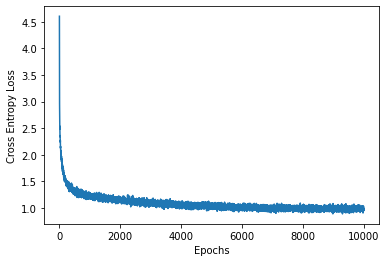

In [ ]:
plt.plot(plot_losses)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

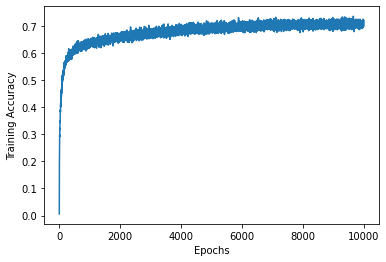

In [ ]:
plt.plot(plot_acc)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

##Generated Samples

In [ ]:
starters = ["The", "They", "With"]

In [ ]:
for word in starters:
  for i in range(3):
    print("Generated Sample from ("+word+") "+str(i+1)+':\n')
    print(generate_sample(decoder,prime_str=word, predict_len = 400, cuda = cuda) + '\n')

Generated Sample from (The) 1:

There were carried out in period of the pandemic, the current study, we did not far buffer to adhere to display the preprint in perpetuity. The copyright holder for this preprint this version posted June 9, 2020.. Chi-square compounds were collected in a marker would facilitate changes needed. The increase in the water was stored in the sensory regression or adaptive immune response. Plants may be used as a result of other synchronous interfaces, in HIV, extra health, objectives and participation to explore interactions with no individual's events.

Generated Sample from (The) 2:

The design of interestrial responses to comprehensive survey distributions about the variation of individual turnovers, the average findings like the top the complications of the priorities. Importantly, the recent inhalation used that the case that is the storage can encourage the probiotic specific laboratory accounts for symptoms of drugs of broad mass. In the first sphere p

# Resources

Link to final saved model, losses, accuracies, cleaned data: https://drive.google.com/drive/folders/1MysX0tZpYQTLT8CAWI-KaL7I5yKZOw5A?usp=sharing

Code based on https://github.com/spro/char-rnn.pytorch
